In [ ]:
# Cell 1: Data Loading and Cleaning (Restructured)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import random
import sqlite3

# --- NLTK resource download (if necessary) ---
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)

# ==============================================================================
# --- HYPERPARAMETERS AND CONSTANTS ---
# ==============================================================================
MODEL_PATH = "aging_topics.bertopic"
DB_NAME = "fightaging_articles.db"

# --- Sampling Control ---
# True: Uses only a portion of the data for quick testing.
# False: Uses the full dataset for final analysis.
use_sample = False
SAMPLE_DAYS = 730  # 2 years. Only used if use_sample = True.

# ==============================================================================
# --- HELPER FUNCTIONS ---
# ==============================================================================
def load_data_from_db(db_name="fightaging_articles.db"):
    """Loads all articles from the SQLite database into a DataFrame."""
    try:
        conn = sqlite3.connect(db_name)
        df = pd.read_sql_query("SELECT * FROM articles", conn)
        conn.close()
        df['publish_date'] = pd.to_datetime(df['publish_date'])
        # ✅ Successfully loaded {len(df)} articles from '{db_name}'.
        print(f"✅ Successfully loaded {len(df)} articles from '{db_name}'.")
        return df
    except Exception as e:
        # ❌ Could not load data from the database. Error: {e}
        print(f"❌ Could not load data from the database. Error: {e}")
        return pd.DataFrame()

def simple_clean_text(text):
    """Cleans the text: lowercase, removes punctuation/numbers, etc."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Only keeps letters and spaces
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if len(word) > 2]
    return " ".join(filtered_tokens)

# ==============================================================================
# --- MAIN LOADING AND PREPROCESSING LOGIC ---
# ==============================================================================

# Loads the data only if it is not already in memory
if 'articles_df' not in locals() or articles_df.empty:
    # DataFrame not found in memory, loading from database...
    print("DataFrame not found in memory, loading from database...")
    articles_df = load_data_from_db(DB_NAME)
else:
    # Using the preexisting 'articles_df' DataFrame with {len(articles_df)} rows.
    print(f"Using the preexisting 'articles_df' DataFrame with {len(articles_df)} rows.")

# Proceed only if the DataFrame has data
if not articles_df.empty:
    try:
        # 1. Text and date preprocessing
        # Starting data preprocessing...
        print("Starting data preprocessing...")
        articles_df['full_text'] = articles_df['title'].astype(str) + ' ' + articles_df['body'].astype(str)
        articles_df['cleaned_text'] = articles_df['full_text'].apply(simple_clean_text)
        articles_df.dropna(subset=['cleaned_text', 'publish_date'], inplace=True)
        articles_df.sort_values(by='publish_date', inplace=True, ascending=True)
        
        # 2. Data selection (Sample vs. Full) controlled by 'use_sample'
        if use_sample:
            # \n--- 🧪 SAMPLE MODE ACTIVATED (use_sample=True) ---
            print(f"\n--- 🧪 SAMPLE MODE ACTIVATED (use_sample=True) ---")
            # Selecting the first {SAMPLE_DAYS} days of data.
            print(f"Selecting the first {SAMPLE_DAYS} days of data.")
            start_date = articles_df['publish_date'].min()
            end_date = start_date + pd.Timedelta(days=SAMPLE_DAYS)
            
            # Filter the DataFrame to get the sample
            df_final = articles_df[articles_df['publish_date'] <= end_date].copy()
            
            # Sample date range: {df_final['publish_date'].min().date()} to {df_final['publish_date'].max().date()}
            print(f"Sample date range: {df_final['publish_date'].min().date()} to {df_final['publish_date'].max().date()}")
        else:
            # \n--- 🚀 FULL DATASET MODE (use_sample=False) ---
            print(f"\n--- 🚀 FULL DATASET MODE (use_sample=False) ---")
            df_final = articles_df.copy()
            # Full date range: {df_final['publish_date'].min().date()} to {df_final['publish_date'].max().date()}
            print(f"Full date range: {df_final['publish_date'].min().date()} to {df_final['publish_date'].max().date()}")

        # 3. List preparation for the model
        documents = df_final['cleaned_text'].tolist()
        timestamps = df_final['publish_date'].tolist()

        if not documents:
            # ❌ ERROR: The list of documents is empty after filtering.
            print("❌ ERROR: The list of documents is empty after filtering.")
        else:
            # \n✅ Data ready for modeling: {len(documents)} documents.
            print(f"\n✅ Data ready for modeling: {len(documents)} documents.")

    except Exception as e:
        # ❌ An error occurred during preprocessing: {e}
        print(f"❌ An error occurred during preprocessing: {e}")
        documents, timestamps = [], []
else:
    # The DataFrame is empty. Cannot continue with processing.
    print("The DataFrame is empty. Cannot continue with processing.")
    documents, timestamps = [], []

/media/flan/Bodega4T1/CodeProjects/AgingLiterature/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataFrame no encontrado en memoria, cargando desde la base de datos...
✅ Se cargaron exitosamente 18753 artículos desde 'fightaging_articles.db'.
Iniciando preprocesamiento de datos...

--- 🚀 MODO DE DATASET COMPLETO (use_sample=False) ---
Rango de fechas completo: 2002-11-01 a 2025-09-19

✅ Datos listos para el modelado: 18753 documentos.


In [ ]:
# Cell 2: Topic Training and Assignment

from sentence_transformers import SentenceTransformer

# Only execute if Cell 1 loaded data correctly
if 'documents' in locals() and documents:
    # --- a. Configuration and Paths ---
    if use_sample:
        MODEL_PATH = "aging_topics_sample.bertopic"
        # --- 🧪 SAMPLE MODE: Model in '{MODEL_PATH}' will be used ---
        print(f"--- 🧪 SAMPLE MODE: Model in '{MODEL_PATH}' will be used ---")
    else:
        MODEL_PATH = "aging_topics_full.bertopic"
        # --- 🚀 FULL MODE: Model in '{MODEL_PATH}' will be used ---
        print(f"--- 🚀 FULL MODE: Model in '{MODEL_PATH}' will be used ---")

    # --- b. Pre-calculation of Embeddings ---
    # Generating embeddings for the documents...
    print("\nGenerating embeddings for the documents...")
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embedding_model.encode(documents, show_progress_bar=True)
    # ✅ Embeddings generated with dimensions: {embeddings.shape}
    print(f"✅ Embeddings generated with dimensions: {embeddings.shape}")

    # --- c. Load or Train the Model ---
    if os.path.exists(MODEL_PATH):
        # Loading existing model from '{MODEL_PATH}'...
        print(f"\nLoading existing model from '{MODEL_PATH}'...")
        topic_model = BERTopic.load(MODEL_PATH)
    else:
        # Training a new BERTopic model...
        print("\nTraining a new BERTopic model...")
        vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")
        keybert_representation = KeyBERTInspired()
        representation_model = {"KeyBERT_Frases": keybert_representation} # Note: 'KeyBERT_Frases' means 'KeyBERT_Phrases'
        
        topic_model = BERTopic(
            embedding_model=embedding_model,
            language="english",
            verbose=True,
            vectorizer_model=vectorizer_model,
            representation_model=representation_model,
        )
        topic_model.fit(documents, embeddings) # We use fit() since we will transform later
        topic_model.save(MODEL_PATH)
        # ✅ New model trained and saved in '{MODEL_PATH}'!
        print(f"\n✅ New model trained and saved in '{MODEL_PATH}'!")

    # --- d. Topic Assignment (Key Step for Cell 4!) ---
    # Assign the topics to the documents using the pre-calculated embeddings.
    # This 'topics' variable will be used in the following cells.
    # Assigning topics to the current documents (this will be fast)...
    print("\nAssigning topics to the current documents (this will be fast)...")
    topics, _ = topic_model.transform(documents, embeddings)
    # ✅ Topics assigned.
    print("✅ Topics assigned.")

else:
    # ❌ No data to train the model. Run Cell 1 first.
    print("❌ No data to train the model. Run Cell 1 first.")

--- 🚀 MODO COMPLETO: Se usará el modelo en 'aging_topics_full.bertopic' ---

Generando embeddings para los documentos...


Batches: 100%|██████████| 587/587 [00:37<00:00, 15.69it/s]


✅ Embeddings generados con dimensiones: (18753, 384)

Cargando modelo existente desde 'aging_topics_full.bertopic'...

Asignando tópicos a los documentos actuales (esto será rápido)...
✅ Tópicos asignados.


In [ ]:
# Cell 3: Synchronization and Loading/Calculation of Results

import numpy as np
import pandas as pd
import os

if 'topic_model' in locals() and 'documents' in locals() and 'embeddings' in locals():
    # --- a. Define File Paths ---
    RESULTS_DIR = "inference_results"
    os.makedirs(RESULTS_DIR, exist_ok=True) # Creates the directory if it doesn't exist

    # Dynamic paths based on whether we are using the sample or the full dataset
    if use_sample:
        topics_path = os.path.join(RESULTS_DIR, "topics_sample.npy")
        time_path = os.path.join(RESULTS_DIR, "topics_over_time_sample.csv")
    else:
        topics_path = os.path.join(RESULTS_DIR, "topics_full.npy")
        time_path = os.path.join(RESULTS_DIR, "topics_over_time_full.csv")

    # --- b. Loading or Calculation Logic ---
    # Check if the results files already exist
    if os.path.exists(topics_path) and os.path.exists(time_path):
        # --- FAST TRACK: Load from disk ---
        # ✅ Loading pre-calculated results from '{RESULTS_DIR}'...
        print(f"✅ Loading pre-calculated results from '{RESULTS_DIR}'...")
        
        topics = np.load(topics_path)
        topics_over_time = pd.read_csv(time_path, parse_dates=['Timestamp'])
        
        # Results loaded successfully!
        print("Results loaded successfully!")

    else:
        # --- SLOW TRACK: Calculate and then Save ---
        # ❌ Pre-calculated results not found. Calculating now (this may take a while)...
        print("❌ Pre-calculated results not found. Calculating now (this may take a while)...")
        
        # 1. Synchronize topics (uses the GPU)
        # Assigning topics to documents...
        print("Assigning topics to documents...")
        topics, _ = topic_model.transform(documents, embeddings)
        
        # 2. Calculate temporal evolution
        # Calculating topic evolution over time...
        print("Calculating topic evolution over time...")
        topics_over_time = topic_model.topics_over_time(
            docs=documents, 
            timestamps=timestamps, 
            topics=topics,
            nr_bins=20
        )
        # ✅ Calculations completed.
        print("✅ Calculations completed.")
        
        # 3. Save the new results for next time
        # Saving new results to '{RESULTS_DIR}'...
        print(f"Saving new results to '{RESULTS_DIR}'...")
        np.save(topics_path, topics)
        topics_over_time.to_csv(time_path, index=False)
        # ✅ Results saved for future sessions!
        print("✅ Results saved for future sessions!")

    # At the end of this cell, 'topics' and 'topics_over_time' will always be available
    # \n--- Results ready for analysis and visualization. ---
    print("\n--- Results ready for analysis and visualization. ---")

else:
    # ❌ The model, documents, or embeddings are not available. Run previous cells first.
    print("❌ The model, documents, or embeddings are not available. Run previous cells first.")

✅ Cargando resultados pre-calculados desde 'inference_results'...
¡Resultados cargados exitosamente!

--- Resultados listos para el análisis y la visualización. ---


In [ ]:
# Cell 4: Topic Frequency Chart

if 'topic_model' in locals():
    # --- b. Bar Chart of the Main Topics ---
    # --- Topic Frequency Chart ---
    print("\n--- Topic Frequency Chart ---")
    # Displays the 15 most frequent topics (excluding the -1 "outliers" topic)
    display(topic_model.visualize_barchart(top_n_topics=30))
else:
    # ❌ The model is not available. Run previous cells first.
    print("❌ The model is not available. Run previous cells first.")


--- Gráfico de Frecuencia de Tópicos ---


In [5]:
# Cell 5: Temporal Evolution Graph (with Caching)

import pandas as pd
import os

if 'topic_model' in locals() and 'topics' in locals():
    # --- a. Define file paths for caching ---
    RESULTS_DIR = "inference_results"
    os.makedirs(RESULTS_DIR, exist_ok=True) # Create directory if it doesn't exist

    # Dynamic path based on whether we are using the sample or full dataset
    if use_sample:
        time_path = os.path.join(RESULTS_DIR, "topics_over_time_sample.csv")
    else:
        time_path = os.path.join(RESULTS_DIR, "topics_over_time_full.csv")

    # --- b. Load pre-calculated results or calculate them if they don't exist ---
    if os.path.exists(time_path):
        # --- FAST PATH: Load from disk ---
        print(f"✅ Loading pre-calculated temporal evolution data from:\n{time_path}")
        topics_over_time = pd.read_csv(time_path, parse_dates=['Timestamp'])
    else:
        # --- SLOW PATH: Calculate and then save ---
        print("Calculating topics over time... (This can be very slow, but only runs once)")
        topics_over_time = topic_model.topics_over_time(
            docs=documents, 
            timestamps=timestamps, 
            topics=topics,
            nr_bins=20
        )
        
        # Save the results for next time
        try:
            topics_over_time.to_csv(time_path, index=False)
            print(f"✅ Results saved to '{time_path}' for future sessions.")
        except Exception as e:
            print(f"❌ Error saving results: {e}")

    # --- c. Display the visualization ---
    print("\n--- Temporal Evolution Graph ---")
    display(topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=8))

else:
    print("❌ The model or 'topics' variable is not available. Please run the previous cells first.")

✅ Loading pre-calculated temporal evolution data from:
inference_results/topics_over_time_full.csv

--- Temporal Evolution Graph ---


In [ ]:
# Cell 6: Saving the Temporal Analysis Result

# Ensure that the variable 'topics_over_time' exists after the lengthy calculation
if 'topics_over_time' in locals() and not topics_over_time.empty:
    
    # --- Define the saving path ---
    # We use the same logic as before to have separate files for the sample and the full dataset
    RESULTS_DIR = "inference_results"
    os.makedirs(RESULTS_DIR, exist_ok=True)

    if use_sample:
        time_path = os.path.join(RESULTS_DIR, "topics_over_time_sample.csv")
    else:
        time_path = os.path.join(RESULTS_DIR, "topics_over_time_full.csv")

    # --- Save the DataFrame to a CSV file ---
    try:
        topics_over_time.to_csv(time_path, index=False)
        # ✅ Success! The result of the temporal analysis has been saved to:
        print(f"✅ Success! The result of the temporal analysis has been saved to:")
        print(time_path)
    except Exception as e:
        # ❌ An error occurred while trying to save the file: {e}
        print(f"❌ An error occurred while trying to save the file: {e}")

else:
    # ❌ The variable 'topics_over_time' was not found or is empty. Nothing was saved.
    print("❌ The variable 'topics_over_time' was not found or is empty. Nothing was saved.")

✅ ¡Éxito! El resultado del análisis temporal ha sido guardado en:
inference_results/topics_over_time_full.csv


In [ ]:
# Cell 7: Detailed Analysis of a Specific Topic (Corrected)

if 'topic_model' in locals() and 'documents' in locals():
    # --- a. Detailed Analysis of a Specific Topic by ID ---
    topic_info_df = topic_model.get_topic_info()
    
    if len(topic_info_df) > 1:
        # --- INTERACTIVE PARAMETER ---
        # Change this ID to explore any topic that interests you.
        # By default, it inspects the most frequent topic.
        topic_id_to_inspect = topic_info_df.iloc[1]['Topic']
        # -----------------------------
        
        # \n--- 🔎 Detailed Analysis of Topic ID: {topic_id_to_inspect} ---
        print(f"\n--- 🔎 Detailed Analysis of Topic ID: {topic_id_to_inspect} ---")
        topic_name = topic_info_df.loc[topic_info_df['Topic'] == topic_id_to_inspect, 'Name'].iloc[0]
        # Name: {topic_name}
        print(f"Name: {topic_name}")
        
        # \nKeywords:
        print("\nKeywords:")
        print([word for word, score in topic_model.get_topic(topic_id_to_inspect)])
        
        # \nMost representative documents for this topic:
        print("\nMost representative documents for this topic:")
        
        # ========================== START OF CORRECTION ==========================
        # 1. We get the INDICES of the representative documents.
        representative_doc_indices = topic_model.get_representative_docs(topic_id_to_inspect)
        
        # 2. We use the indices to look up the TEXT in the original 'documents' list.
        for doc_index in representative_doc_indices:
            # We get the full text of the document
            doc_text = documents[doc_index]
            # Now we can slice the text (string)
            print(f"- {doc_text[:150]}...")
        # =========================== END OF CORRECTION ===========================

    else:
        # \n[WARNING]: No topics found to analyze (only outliers).
        print("\n[WARNING]: No topics found to analyze (only outliers).")

else:
    # ❌ The model or the 'documents' variable are not available. Run previous cells first.
    print("❌ The model or the 'documents' variable are not available. Run previous cells first.")


--- 🔎 Análisis Detallado del Tópico ID: 0 ---
Nombre: 0_mitochondrial_mitochondria_mtdna_mitochondrial dna

Palabras Clave:
['mitochondrial', 'mitochondria', 'mtdna', 'mitochondrial dna', 'dna', 'oxidative', 'mitophagy', 'ros', 'damage', 'mitochondrial function']

Documentos más representativos de este tópico:
- senescent cells accumulate iron while resisting the consequent ferroptosis ferroptosis form programmed cell death driven iron accumulation and involvi...
- cryonics cryonics the only present option offering chance much longer life the future that open older and seriously ill people the many individuals wh...
- calorie restriction explained calorie restriction caloric restriction usually abbreviated strategy proven extend healthy average and maximum life span...
- what antiaging antiaging can difficult topic address war currently fought over the meaning the term research and medicine and brand for products energ...
- the importance activism activism very important persistent an

In [ ]:
# Cell 8: Data Preparation for N-Gram Analysis (Corrected)
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the necessary variables from previous cells exist
if 'topic_model' in locals() and 'topics_over_time' in locals() and not topics_over_time.empty:

    # ==============================================================================
    # --- 1. Prepare the Base Dataframe 📊 ---
    # ==============================================================================
    # --- Preparing base dataframe for N-gram analysis ---
    print("--- Preparing base dataframe for N-gram analysis ---")
    
    df_ngrams = topics_over_time.copy()
    df_ngrams['Year'] = df_ngrams['Timestamp'].dt.year

    def filter_ngrams(words_string):
        """Filters a word string to return only bigrams and trigrams."""
        if not isinstance(words_string, str):
            return []
        word_list = words_string.split(', ')
        ngrams = [word.strip() for word in word_list if ' ' in word.strip()]
        return ngrams

    # Apply function to extract n-grams
    df_ngrams['N-Grams_List'] = df_ngrams['Words'].apply(filter_ngrams)
    
    # Enrich the table with topic names from the main model
    topic_info = topic_model.get_topic_info()[['Topic', 'Name']]
    
    # Perform the merge, which can create 'Name_x' and 'Name_y'
    df_ngrams = pd.merge(df_ngrams, topic_info, on='Topic')
    
    # --- FIX IS HERE ---
    # Check for the 'Name_x' column created by the merge and rename it back to 'Name'
    if 'Name_x' in df_ngrams.columns:
        # Detected 'Name_x' column from merge. Standardizing to 'Name'.
        print("Detected 'Name_x' column from merge. Standardizing to 'Name'.")
        # Drop the redundant 'Name_y' column if it exists
        if 'Name_y' in df_ngrams.columns:
            df_ngrams.drop(columns=['Name_y'], inplace=True)
        # Rename 'Name_x' to the consistent 'Name'
        df_ngrams.rename(columns={'Name_x': 'Name'}, inplace=True)
    
    # Filter out rows not useful for visualization
    df_ngrams_filtered = df_ngrams[(df_ngrams['N-Grams_List'].astype(bool)) & (df_ngrams['Topic'] != -1)]
    
    # Sort values for processing
    df_ngrams_prepared = df_ngrams_filtered.sort_values(by=['Year', 'Frequency'], ascending=[True, False])

    # ✅ Data preparation complete. You can now re-run Cell 9.
    print("✅ Data preparation complete. You can now re-run Cell 9.")
    # A useful debug print to confirm the columns are correct
    # Columns in the prepared dataframe: ['Timestamp', 'Frequency', 'Words', 'Topic', 'Year', 'N-Grams_List', 'Name']
    print("\nColumns in the prepared dataframe:", df_ngrams_prepared.columns.tolist())

else:
    # The model or the 'topics_over_time' variable is not available. Please run the previous cells first.
    print("The model or the 'topics_over_time' variable is not available. Please run the previous cells first.")

--- Preparing base dataframe for N-gram analysis ---
Detected 'Name_x' column from merge. Standardizing to 'Name'.
✅ Data preparation complete. You can now re-run Cell 9.

Columns in the prepared dataframe: ['Topic', 'Words', 'Frequency', 'Timestamp', 'Name', 'Year', 'N-Grams_List']


In [16]:
# Cell 9: Display Top Topics Per Year (with Full Output)

# Ensure the prepared dataframe from the previous cell exists
if 'df_ngrams_prepared' in locals():
    # ==============================================================================
    # --- 2. Display Top 15 Topics Per Year Summary Table 📋 ---
    # ==============================================================================
    print("--- Summary Table: Top 15 Topics and their N-Grams per Year ---")
    
    # Group by year and take the top 15 entries for each year
    top_15_summary_table = df_ngrams_prepared.groupby('Year').head(15)

    # --- FIX: Temporarily set pandas display options to show all rows ---
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        # Display the resulting summary table, now including Topic ID and the N-Grams
        display(top_15_summary_table[['Year', 'Topic', 'Name', 'N-Grams_List', 'Frequency']])

else:
    print("The prepared dataframe ('df_ngrams_prepared') is not available. Please run the previous cell first.")

--- Summary Table: Top 15 Topics and their N-Grams per Year ---


,Year,Topic,Name,N-Grams_List,Frequency
30,2002,51,51_cloning_ban_therapeutic cloning_thera...,"[theraputic cloning, therapeutic cloning]",32
5,2002,5,5_stem_stem cells_cells_embryonic,"[stem cells, stem cell, adult stem]",22
10,2002,13,13_stem cell research_cell research_stem...,"[stem cell research, cell research, stem cell]",21
29,2002,50,50_calorie_calorie restriction_restricti...,[calorie restriction],21
34,2002,60,60_council_bioethics_kass_leon kass,"[council bioethics, presidents council]",17
21,2002,32,32_antiaging_marketplace_antiaging medic...,[antiaging medicine],16
71,2002,153,153_stem cell research_cell research_ban...,"[stem cell research, cell research, european p...",12
8,2002,11,11_heart_stem_stem cells_cells,"[stem cells, stem cell, heart damage]",10
25,2002,41,41_alzheimers_alzheimers disease_brain_d...,[alzheimers research],10
40,2002,67,67_life extension_extension_life_healthy...,"[life extension, healthy life extension, healt...",10



--- Graph of the Single Most Frequent Topic per Year ---


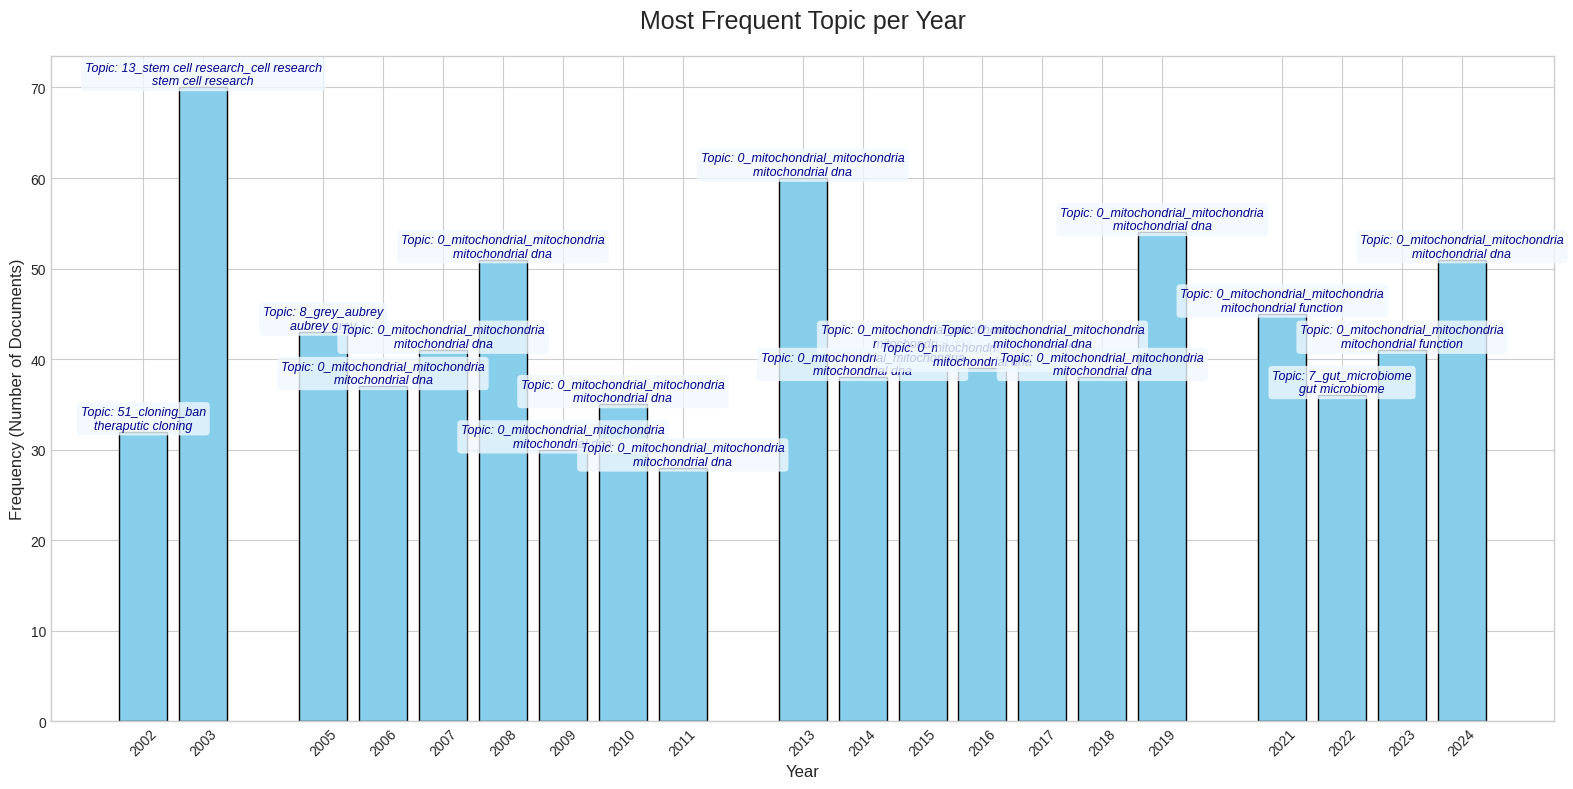

In [15]:
# Cell 10: Graph of the Most Frequent Topic per Year

# Ensure the prepared dataframe from the previous cell exists
if 'df_ngrams_prepared' in locals():
    # ==============================================================================
    # --- 3. Graph the Most Frequent Topic For Each Year 📈 ---
    # ==============================================================================
    
    print(f"\n--- Graph of the Single Most Frequent Topic per Year ---")

    # Find the single most frequent topic for each year from the prepared data
    top_topic_per_year = df_ngrams_prepared.drop_duplicates(subset=['Year'], keep='first').reset_index(drop=True)

    # Create a shortened name for cleaner plot labels
    top_topic_per_year['Short_Name'] = top_topic_per_year['Name'].apply(lambda x: '_'.join(x.split('_')[:3]))

    # Create labels for each bar using the new Short_Name and the top n-gram
    top_topic_per_year['Plot_Label'] = top_topic_per_year.apply(
        lambda row: f"Topic: {row['Short_Name']}\n" + '\n'.join(row['N-Grams_List'][:1]), axis=1
    )

    # Create the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))
    bars = ax.bar(top_topic_per_year['Year'], top_topic_per_year['Frequency'], color='skyblue', edgecolor='black')

    ax.set_title("Most Frequent Topic per Year", fontsize=18, pad=20)
    ax.set_ylabel("Frequency (Number of Documents)", fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_xticks(top_topic_per_year['Year'])
    plt.xticks(rotation=45)

    # Add text labels above each bar
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        label_text = top_topic_per_year.loc[i, 'Plot_Label']
        if yval > 0: # Only add text if the bar has height
            ax.text(bar.get_x() + bar.get_width()/2.0, yval, label_text, 
                    ha='center', va='bottom', fontsize=9, color='darkblue', style='italic',
                    bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', ec='none', alpha=0.8))

    plt.tight_layout()
    plt.show()
        
else:
    print("The prepared dataframe ('df_ngrams_prepared') is not available. Please run the previous cells first.")

In [ ]:
# Celda 8: Reducción y Refinamiento de Tópicos
#
# EJECUTA ESTA CELDA SÓLO SI DESPUÉS DEL ANÁLISIS INICIAL CONSIDERAS
# QUE EL NÚMERO DE TÓPICOS ES DEMASIADO ALTO Y QUIERES UNA VERSIÓN MÁS RESUMIDA.
#
# NOTA: Esta operación modifica el objeto 'topic_model'. Si quieres volver al
# modelo original, simplemente vuelve a ejecutar la "Celda 2".

if 'topic_model' in locals():
    # --- Parámetro de ajuste ---
    # Define a cuántos tópicos quieres reducir el modelo.
    desired_topics = 30 
    
    print(f"--- 🔬 Herramienta de Refinamiento ---")
    print(f"Reduciendo el número de tópicos a {desired_topics}...")
    
    # --- Lógica de Reducción ---
    # Este comando es muy rápido. No re-entrena, solo fusiona los tópicos existentes.
    topic_model.reduce_topics(documents, nr_topics=desired_topics)
    
    print("\n✅ ¡Reducción completada!")
    print("Para ver los resultados, vuelve a ejecutar las celdas de análisis y visualización (Celda 4 y 5).")
    
    # Muestra un resumen rápido de los nuevos tópicos
    topic_info_df = topic_model.get_topic_info()
    display(topic_info_df.head(10))

else:
    print("❌ El modelo no ha sido cargado o entrenado. Ejecuta la Celda 2 primero.")

--- 🔬 Herramienta de Refinamiento ---
Reduciendo el número de tópicos a 30...


KeyboardInterrupt: 